In [92]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.models import load_model
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.datasets import cifar10
import math
import itertools
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
plt.ioff()  # not to show images inline

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [2]:
generator = load_model("out3/cifar10-generator_0100000.h5")

(40, 32, 32, 3) 0 254


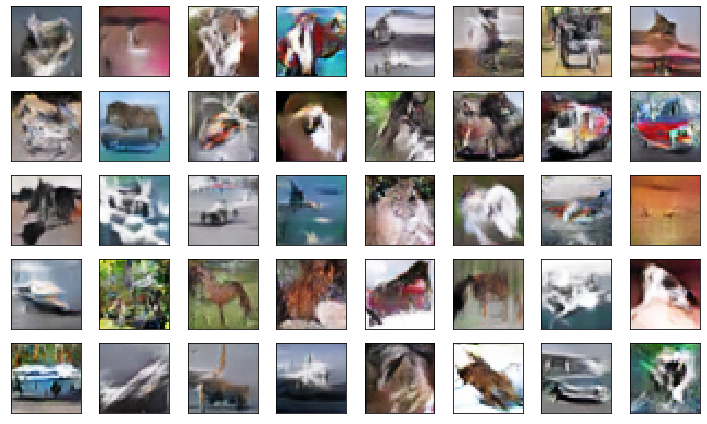

In [67]:
def plot_images(images, titles=None, nrow=5, ncol=8, figsize=(10, 6)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i, j in itertools.product(range(nrow), range(ncol)):
        k = i*ncol + j
        if nrow > 1 and ncol > 1:
            a = ax[i][j] 
        elif nrow > 1:
            a = ax[i]
        elif ncol > 1:
            a = ax[j]
        else:
            a = ax
        if k < len(images):
            a.imshow(images[k])
            if titles is not None:
                a.set_title(titles[k])
        a.xaxis.set_visible(False)
        a.yaxis.set_visible(False)
    fig.tight_layout()
    plt.close(fig)
    return fig

def generate_latent(generator, n_sample=128, seed=None):
    np.random.seed(seed)
    latent_size = generator.input_shape[1]
    latent = np.random.randn(n_sample, latent_size)
    return latent

def generate_images(generator, latents):
    faces = generator.predict(latents)
    faces = ((faces+1)*255/2).astype(int)
    return faces

latents = generate_latent(generator, 40)
images = generate_images(generator, latents)
print(images.shape, np.min(images), np.max(images))
plot_images(images, nrow=5, ncol=8)

In [65]:
model = inception_v3.InceptionV3()

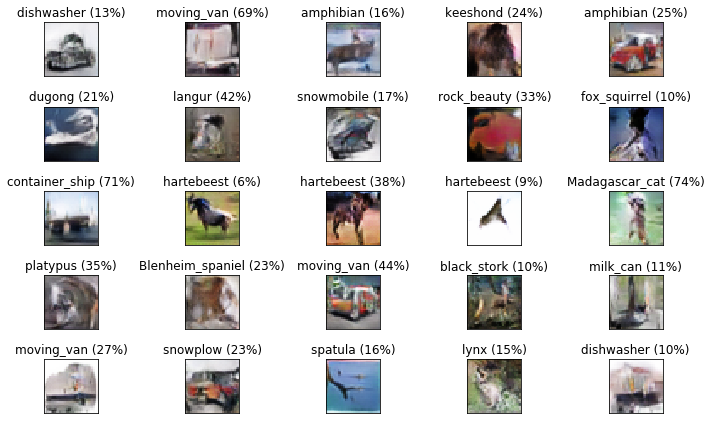

In [68]:
def predict_proba(model, images):
    target_shape = model.input_shape[1:-1]
    tmp = images.astype("uint8")
    tmp = [Image.fromarray(i) for i in tmp]
    tmp = [i.resize(target_shape) for i in tmp]
    tmp = [np.array(i) for i in tmp]
    tmp = np.array(tmp)
    tmp = tmp.astype("float32")
    #print(tmp.shape, np.min(tmp), np.max(tmp))
    tmp = inception_v3.preprocess_input(tmp)
    #print(tmp.shape, np.min(tmp), np.max(tmp))
    pred = model.predict(tmp)
    return pred

def prediction_to_label(pred):
    tmp = inception_v3.decode_predictions(pred)
    tmp = [t[0] for t in tmp]  # only top prediction
    return ["%s (%.0f%%)" % (x, 100*p) for _, x, p in tmp] 

latents = generate_latent(generator, 25)
images = generate_images(generator, latents)
pred = predict_proba(model, images)
labels = prediction_to_label(pred)
plot_images(images, labels, nrow=5, ncol=5)

# Inception Score

$$
\mathrm{IS} = \frac{1}{n}\sum_{i=1}^{n} \sum_{j} p(y_j | x_i) \left( \log p(y_j | x_i) - \log p(y_j) \right),
$$
which can be decomposed into

1. $\frac{1}{n}\sum_{i=1}^{n} \sum_{j} p(y_j | x_i) \log p(y_j | x_i)$
2. $- \frac{1}{n}\sum_{i=1}^{n} \sum_{j} p(y_j | x_i) \log p(y_j)$ 

1 is the average of the negative entropy of the predicted probability.  A low entropy means that the probability is concentrated to certain classes, i.e. the image is highly recognizable.  Hence, a high score indicates the image quality is high.

2 equals $- \sum_{j} p(y_j) \log p(y_j)$, which is the entropy of the marginal probability. A high entropy means that probabilities are evenly distributed across classes.  Hence, a high score indicates the image variation is high.

In [84]:
def _inception_score(probs, eps=1e-6):
    # probs: array of shape (samples, classes)
    marginal_prob = np.mean(probs, axis=0, keepdims=True) # (1, classes)
    tmp = probs * (np.log(probs+eps) - np.log(marginal_prob+eps))
    tmp = np.sum(tmp, axis=1)
    tmp = np.mean(tmp, axis=0)
    score = np.exp(tmp)
    return score

def compute_inception_score(model, images, eps=1e-6):
    probs = predict_proba(model, images)
    return _inception_score(probs, eps=eps)

# test
# perfect model gets the score equals to the number of classes
probs = np.array([[1,0,0], [0,1,0], [0,0,1]])
print(_inception_score(probs))

# images with low quality gets the score 1
probs = np.array([[1/3,1/3,1/3], [1/3,1/3,1/3], [1/3,1/3,1/3]])
print(_inception_score(probs))

# images with no variation gets the score 1
probs = np.array([[1,0,0], [1,0,0], [1,0,0]])
print(_inception_score(probs))

2.999994000018
1.0
1.0


In [89]:
def evaluate_inception_scores(model, images, splits=10, eps=1e-6):
    # shuffle images
    ix = np.random.permutation(len(images))
    images = images[ix]
    
    n = len(images)
    batchsize = int(n / splits)
    nbatch = math.ceil(n / batchsize)
    scores = []
    for i in range(nbatch):
        i1 = i*batchsize
        i2 = i1 + batchsize
        score = compute_inception_score(model, images[i1:i2], eps=eps)
        scores.append(score)
    avg = np.mean(scores)
    se = np.std(scores) / (splits**0.5)
    return avg, se

In [91]:
evaluate_inception_scores(model, images)

(1.5700632, 0.06928871203334729)

In [ ]:
# Evaluate scores for cifar10 data as a benchmark
(x_tr, y_tr), (x_te, y_te) = cifar10.load_data()
print(x_tr.shape, y_tr.shape, x_te.shape, y_te.shape)
print(np.min(x_tr), np.max(x_tr), np.min(x_te), np.max(x_tr))
evaluate_inception_scores(model, x_tr[0:1000])

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
0 255 0 255
